In [1]:
import numpy as np
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [5]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [10]:
query = '''select c.name as Category, rental_duration, rental_rate, length, replacement_cost, rating
from film as a
join film_category as b
on a.film_id = b.film_id
join category as c
on b.category_id = c.category_id
where c.category_id < 5'''

In [11]:
data = pd.read_sql_query(query, engine)
data.head()

,Category,rental_duration,rental_rate,length,replacement_cost,rating
0,Action,6,0.99,113,20.99,PG
1,Action,3,4.99,129,17.99,R
2,Action,5,2.99,168,11.99,NC-17
3,Action,6,0.99,68,25.99,NC-17
4,Action,6,2.99,129,15.99,G


In [13]:
data.shape

(247, 6)

In [17]:
data['rental_duration'] = data['rental_duration'].astype('object')
data['rental_rate'] = data['rental_rate'].astype('object')
data['replacement_cost'] = data['replacement_cost'].astype('object')
data['rating'] = data['rating'].astype('object')

In [18]:
data.isna().sum() 

Category            0
rental_duration     0
rental_rate         0
length              0
replacement_cost    0
rating              0
dtype: int64

In [27]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import probplot
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [28]:
def feat_log_box(df, feature, bins):
    """makes a log Transformation and a boxcox transformation of a feature of a dataframe. \n
    0 values are replaced with the mean in the transformation: \n
    plots 3 distplots next to each other for comparison \n
    tales 3 arguments (df, feature, bins)"""
    df[feature+'_log'] = list(map(lambda x: np.log(x) if np.isfinite(x) else np.NAN, df[feature]))
    df[feature+'_log'] = df[feature+'_log'].fillna(np.mean(df[feature+'_log']))
    df[feature+'_boxcox'] = np.where(df[feature]<=0,0,df[feature])
    mean = np.sum(df[feature+'_boxcox'])/len(df[df[feature+'_boxcox']>0])
    df[feature+'_boxcox'] = df[feature+'_boxcox'].replace(0,mean)
    xt, lmbda = stats.boxcox(df[feature+'_boxcox'])
    df[feature+'_boxcox'] = xt
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,4))
    sns.distplot(df[feature], bins, ax=ax1)
    ax1.set_title(feature)
    sns.distplot(df[feature+'_log'], bins, ax=ax2)
    ax2.set_title(feature + '_log')
    sns.distplot(xt, bins, ax=ax3)
    ax3.set_title(feature + '_boxcox')

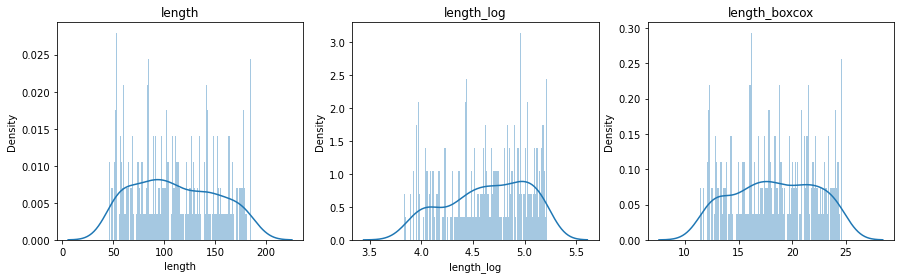

In [29]:
feat_log_box(data,'length',120)

In [30]:
data.head()

,Category,rental_duration,rental_rate,length,replacement_cost,rating,length_log,length_boxcox
0,Action,6,0.99,113,20.99,PG,4.727388,18.870699
1,Action,3,4.99,129,17.99,R,4.859812,20.282343
2,Action,5,2.99,168,11.99,NC-17,5.123964,23.389407
3,Action,6,0.99,68,25.99,NC-17,4.219508,14.236858
4,Action,6,2.99,129,15.99,G,4.859812,20.282343


In [32]:
data = data.drop(['length_log','length'],axis=1)

In [37]:
from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import StandardScaler
import numpy as np
X = data.select_dtypes(include = np.number)

# Normalizing data
transformer = Normalizer().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)

In [34]:
cat = data.select_dtypes(include = np.object)
cat = cat.drop(['Category'], axis=1)
categorical = pd.get_dummies(cat, columns=['rental_duration', 'rental_rate', 'replacement_cost', 'rating'])

In [35]:
Y = data['Category']

In [38]:
X = np.concatenate((x,categorical), axis=1)

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=100)

In [42]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [43]:
classification.score(X_test, y_test)

0.2222222222222222

In [44]:
predictions = classification.predict(X_test)

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[ 7,  6, 10,  1],
       [ 7,  5,  9,  4],
       [ 6,  4,  6,  6],
       [ 6,  9,  9,  4]])

In [16]:
data['replacement_cost'].value_counts()

12.99    19
29.99    19
27.99    17
14.99    15
13.99    14
28.99    14
22.99    13
18.99    12
16.99    12
23.99    12
24.99    11
26.99    11
20.99    10
21.99    10
19.99     9
17.99     9
10.99     9
11.99     9
15.99     8
25.99     7
9.99      7
Name: replacement_cost, dtype: int64